# MOVIE RECOMMENDATION SYSTEM

### Install Required Libraries
Before running the project, make sure you have all the necessary Python libraries installed by executing the following command:


In [2]:
!pip install matplotlib seaborn pandas numpy


### Loading the Datasets

In [4]:
import pandas as pd

movies = pd.read_csv("C:/Users/Prajwal/Downloads/archive/tmdb_5000_movies.csv")
credits = pd.read_csv("C:/Users/Prajwal/Downloads/archive/tmdb_5000_credits.csv")

# Merge datasets on title
movies = movies.merge(credits, on='title')

movies.head(2)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,movie_id,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,19995,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,285,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."


###  Data Cleaning
In this step, we select only the necessary columns for building our recommendation system and handle any missing values.  
We keep the following columns:  
`movie_id`, `title`, `overview`, `genres`, `keywords`, `cast`, and `crew`.  

Then, we check for null values and remove any rows containing missing data to ensure data consistency.


In [5]:
movies = movies[['movie_id', 'title', 'overview', 'genres', 'keywords', 'cast', 'crew']]
movies.isnull().sum()
movies.dropna(inplace=True)


### Data Preprocessing — Extracting Useful Information

In this step, we process the **`genres`**, **`keywords`**, **`cast`**, and **`crew`** columns which are stored as stringified lists (JSON format).  
We use the `ast.literal_eval()` function to safely evaluate these strings into Python objects and extract only the relevant data:

- **`genres`** → Extracts the list of genre names.  
- **`keywords`** → Extracts the list of keywords.  
- **`cast`** → Keeps only the top 3 cast members for each movie.  
- **`crew`** → Extracts only the **Director's** name from the crew list.  

This transformation simplifies our dataset and makes it ready for content-based filtering.


In [6]:
import ast

def convert(obj):
    L = []
    for i in ast.literal_eval(obj):
        L.append(i['name'])
    return L

movies['genres'] = movies['genres'].apply(convert)
movies['keywords'] = movies['keywords'].apply(convert)
movies['cast'] = movies['cast'].apply(lambda x: [i['name'] for i in ast.literal_eval(x)[:3]])  # top 3 cast
movies['crew'] = movies['crew'].apply(lambda x: [i['name'] for i in ast.literal_eval(x) if i['job'] == 'Director'])


### Feature Engineering — Creating the “Tags” Column

Now that we have cleaned and extracted the necessary features, we combine them into a single **`tags`** column.  
This column represents the overall content of each movie, merging its **overview**, **genres**, **keywords**, **top cast**, and **director** into one textual field.

Steps performed:
1. **Tokenization** – The `overview` column is split into individual words.  
2. **Merging Features** – All relevant columns (`overview`, `genres`, `keywords`, `cast`, and `crew`) are concatenated to form a unified text representation.  
3. **Final Cleanup** – The combined list is joined back into a single string and converted to lowercase for uniformity.

This `tags` column will be used to compute the **similarity** between movies in the recommendation model.


In [7]:
movies['overview'] = movies['overview'].apply(lambda x: x.split())

movies['tags'] = movies['overview'] + movies['genres'] + movies['keywords'] + movies['cast'] + movies['crew']

new_df = movies[['movie_id', 'title', 'tags']]
new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))
new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())

new_df.head()


C:\Users\Prajwal\AppData\Local\Temp\ipykernel_3736\313495039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: " ".join(x))
C:\Users\Prajwal\AppData\Local\Temp\ipykernel_3736\313495039.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['tags'] = new_df['tags'].apply(lambda x: x.lower())


,movie_id,title,tags
0,19995,Avatar,"in the 22nd century, a paraplegic marine is di..."
1,285,Pirates of the Caribbean: At World's End,"captain barbossa, long believed to be dead, ha..."
2,206647,Spectre,a cryptic message from bond’s past sends him o...
3,49026,The Dark Knight Rises,following the death of district attorney harve...
4,49529,John Carter,"john carter is a war-weary, former military ca..."


### Text Vectorization — Converting movie tags into numerical vectors using **CountVectorizer** with 5000 max features and English stop words.


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(max_features=5000, stop_words='english')
vectors = cv.fit_transform(new_df['tags']).toarray()


### Computing Similarity — Calculating cosine similarity between movie vectors to measure how similar each pair of movies is.


In [9]:
from sklearn.metrics.pairwise import cosine_similarity

similarity = cosine_similarity(vectors)


### Movie Recommendation Function — Retrieves the top 5 movies most similar to a given movie title based on cosine similarity scores.


In [10]:
def recommend(movie):
    movie = movie.lower()
    index = new_df[new_df['title'].str.lower() == movie].index[0]
    distances = similarity[index]
    movies_list = sorted(list(enumerate(distances)), reverse=True, key=lambda x: x[1])[1:6]
    
    print(f"\n🎬 Movies similar to '{movie.title()}':\n")
    for i in movies_list:
        print(new_df.iloc[i[0]].title)


### Example

In [11]:
recommend('Avatar')



🎬 Movies similar to 'Avatar':

Aliens
Moonraker
Alien
Alien³
Silent Running


### Model Saving — Storing the processed movie data and similarity matrix using Pickle for future use without retraining.


In [12]:
import pickle

pickle.dump(new_df, open('movies.pkl','wb'))
pickle.dump(similarity, open('similarity.pkl','wb'))


## EDA(Exploratory Data Analysis)

### Data Visualization — Most Common Movie Genres

In this step, we visualize the distribution of movie genres in the dataset.

**Process:**
1. The `genres` column is converted from a string format to a list using `ast.literal_eval()` (if necessary).  
2. All genres are flattened into a single list so that each genre can be counted individually.  
3. Using the `Counter` class, we count how many times each genre appears across all movies.  
4. Finally, we create a horizontal bar plot using **Seaborn** to display the most common movie genres and their frequency.

This visualization helps us understand which genres are most frequently represented in the dataset.


C:\Users\Prajwal\AppData\Local\Temp\ipykernel_3736\2941530157.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(genre_counts.values()), y=list(genre_counts.keys()), palette='mako')


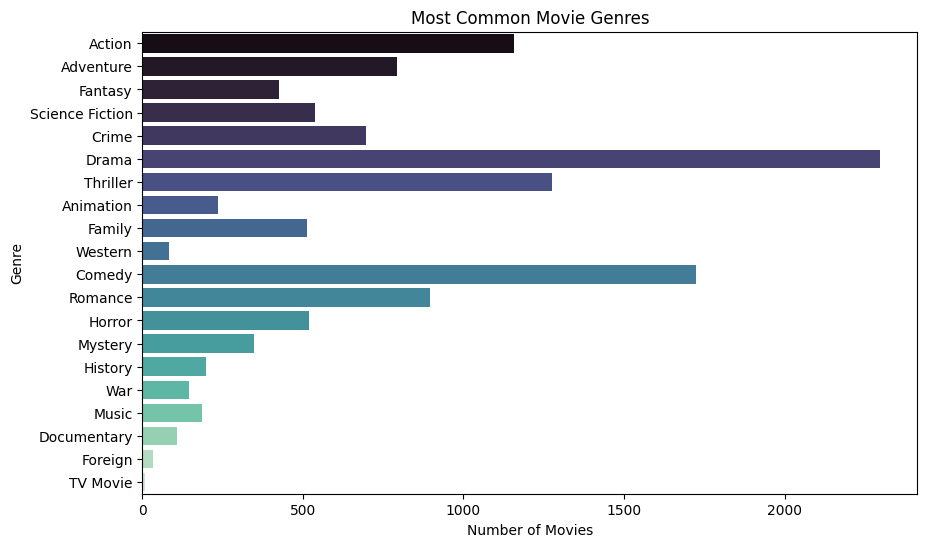

In [23]:
import matplotlib.pyplot as plt
from collections import Counter
import ast

# Convert genres column from string to list if needed
movies['genres'] = movies['genres'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten the list of all genres
all_genres = [genre['name'] if isinstance(genre, dict) else genre for sublist in movies['genres'] for genre in sublist]
genre_counts = Counter(all_genres)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=list(genre_counts.values()), y=list(genre_counts.keys()), palette='mako')
plt.title('Most Common Movie Genres')
plt.xlabel('Number of Movies')
plt.ylabel('Genre')
plt.show()


### Data Visualization — Top 10 Most Frequent Actors

In this section, we analyze which actors appear most frequently across the movies in the dataset.

**Steps:**
1. The **`cast`** column is converted from string format to a list using `ast.literal_eval()` if required.  
2. We flatten all cast lists to create a single list of actor names.  
3. Using the **`Counter`** class, we count the frequency of each actor and select the **top 10 most frequent** ones.  
4. Finally, we visualize these actors with a horizontal bar chart using **Seaborn**.

This helps identify the most popular or frequently featured actors in the dataset.


C:\Users\Prajwal\AppData\Local\Temp\ipykernel_3736\2250906386.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[count for _, count in actor_counts], y=[actor for actor, _ in actor_counts], palette='viridis')


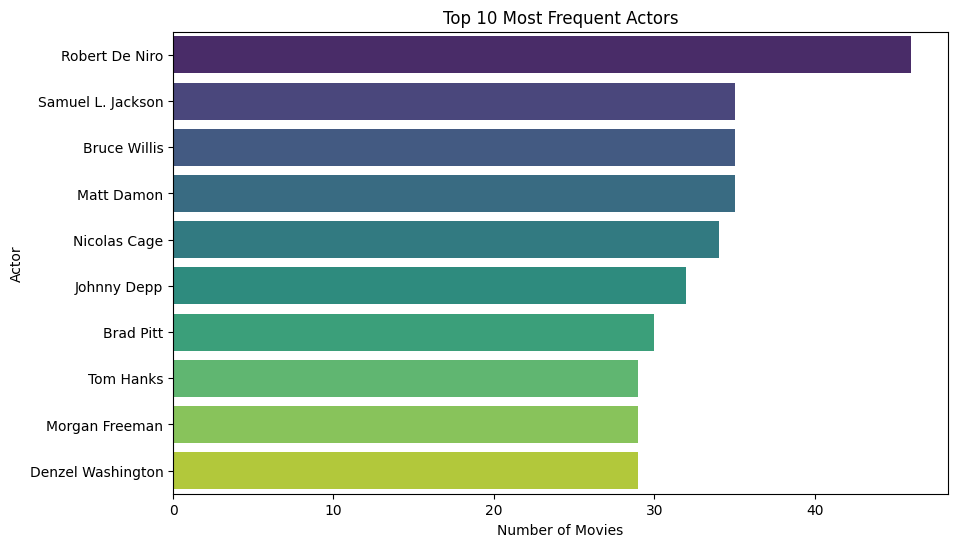

In [24]:
from itertools import chain

# Convert cast column to list
movies['cast'] = movies['cast'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Flatten and count
all_cast = [actor['name'] if isinstance(actor, dict) else actor for sublist in movies['cast'] for actor in sublist]
actor_counts = Counter(all_cast).most_common(10)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x=[count for _, count in actor_counts], y=[actor for actor, _ in actor_counts], palette='viridis')
plt.title('Top 10 Most Frequent Actors')
plt.xlabel('Number of Movies')
plt.ylabel('Actor')
plt.show()


## Conclusion

In this project, we successfully built a **Movie Recommendation System** using content-based filtering techniques.  
By analyzing key metadata such as **overview**, **genres**, **keywords**, **cast**, and **crew**, we created a unified representation of each movie in the form of text-based **tags**.  
Using **CountVectorizer**, these textual features were transformed into numerical vectors, and **Cosine Similarity** was used to measure the closeness between movies.

The system is capable of suggesting movies similar to a given input title based purely on content similarities — without relying on user ratings or watch history.  
Additionally, visualizations like **genre distribution** and **frequent actors** provided deeper insights into the dataset.

Overall, this project demonstrates how **Natural Language Processing (NLP)** and **Machine Learning** techniques can be effectively combined to create a practical and interactive movie recommendation tool.
